In [4]:
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
import cartopy.io.img_tiles as cimgt
import plotly.express as px
import plotly.graph_objects as go
import time
from datetime import datetime, timedelta






In [5]:
pd.set_option("display.max_rows", None) 
pd.set_option("display.max_columns", None)

In [6]:
#df = pd.read_json('/Users/barry/CodeAcademy/Sea_watch/sample_traces/2022_09_407637.json')
df = pd.read_json('sample_traces/2021_01_346401.json')

In [7]:
import os
import types

import cartopy.io.img_tiles as img_tiles
import requests
import PIL

class CachedTiler(object):
    def __init__(self, tiler):
        self.tiler = tiler

    def __getattr__(self, name):
        attr = getattr(self.tiler, name, None)
        if isinstance(attr, types.MethodType):
            attr = types.MethodType(attr.__func__, self)
        return attr

    def get_image(self, tile):
        tileset_name = '{}'.format(self.tiler.__class__.__name__.lower())
        cache_dir = os.path.expanduser(os.path.join('~/', 'image_tiles', tileset_name))
        if not os.path.exists(cache_dir):
            os.makedirs(cache_dir)
        tile_fname = os.path.join(cache_dir, '_'.join(str(v) for v in tile) + '.png')
        if not os.path.exists(tile_fname):
            response = requests.get(self._image_url(tile),
                                    stream=True)

            with open(tile_fname, "wb") as fh:
                for chunk in response:
                    fh.write(chunk)
        with open(tile_fname, 'rb') as fh:
            img = PIL.Image.open(fh)
            img = img.convert(self.desired_tile_form)     
        return img, self.tileextent(tile), 'lower'


plane: 342555
take_off: 2022-02-01 16:49:13


/Users/barry/anaconda3/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/barry/anaconda3/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


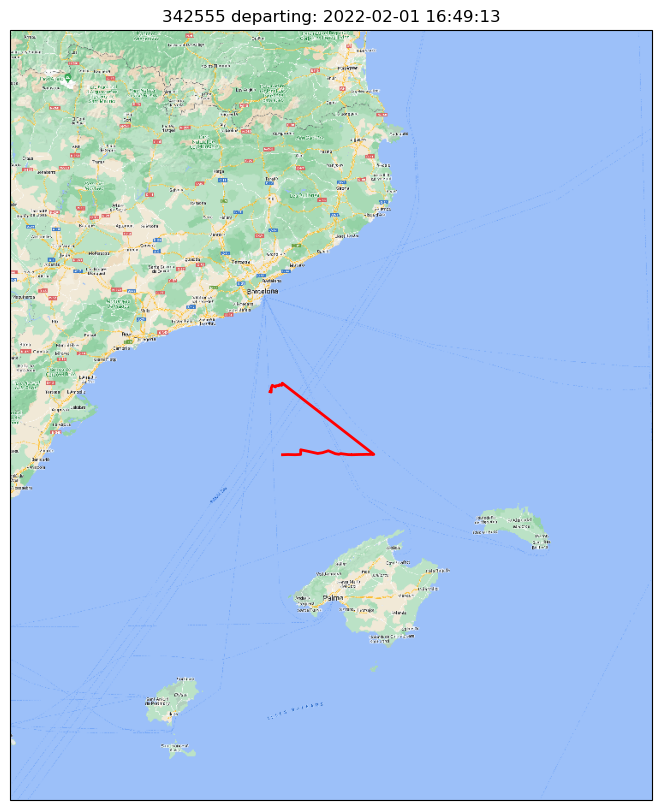

In [8]:
def route_maker(file_path):
    df = pd.read_json(file_path)

    if 'icao' in df.columns:
        icao = df.icao.unique()[0]
    elif 'hex' in df.columns:
        icao = df.hex.unique()[0]
    time_stamp = df.timestamp.unique()[0]
    time_stamp = pd.to_datetime(time_stamp).round('1s')
    timeline = []
    latitude = []
    longitude = []
    altitude = []

    for val in df.trace:
        timeline.append(val[0])
        latitude.append(val[1])
        longitude.append(val[2])
        altitude.append(val[3])
   
    print(f'plane: {icao}\ntake_off: {time_stamp}')
    flight_info = zip(timeline, latitude, longitude, altitude)

    # Initialize our Google Maps tiles
    actual_tiler = cimgt.GoogleTiles()
    imagery = CachedTiler(actual_tiler)


    fig = plt.figure(figsize=(10,10), facecolor='white')
    ax = fig.add_subplot(projection=ccrs.LambertConformal(central_longitude=0))
    plt.title(f'{icao} departing: {time_stamp}')

    # Set the boundaries around the map
    ax.set_extent([ 
        max(longitude) +2, min(longitude) - 2,
        min(latitude) -2 , max(latitude) +2
    ], crs=ccrs.Geodetic())

    # Draw the background
    ax.add_image(imagery, 9)

    # Draw the path of the fligt
    track = sgeom.LineString(zip(longitude,latitude))
    ax.add_geometries([track],
                      ccrs.PlateCarree(),
                      facecolor='none',
                      edgecolor='red',
                      linewidth=2)    

route_maker('sample_highres_traces/2022_02_01_342555.json')



route_maker3 takes a file name and then creates an interative plotly map showing altitude as well as location

## FUNCTION: route_maker2

The `route_maker2` function processes a JSON input representing a series of points in space, and generates a map of the route. Additionally, it features the ability to track directional changes between points. If the cumulative directional change adds up to 360 degrees, it indicates that the plane has completed a full rotation.

### Functionality:

1. **Input:**
   - The function takes a JSON object as input

2. **Mapping:**
   - The primary functionality involves mapping the points provided in the JSON

3. **Directional Change Tracking:**
   - The function keeps track of directional changes between consecutive points.

4. **360-Degree Rotation Detection:**
   - If the cumulative change between given points exceeds 360 degrees it means it has completed an 'orbit' in that time period

### To be checked
1. **anti-clockwise**
   -Does it work both directions -I think it does but need to check
2. **way to track the number of orbits**


In [60]:
def map_drawer(dataframe, icao, time_stamp, index_range=None):
    fig = px.scatter_mapbox(dataframe, 
                            lon='Longitude', 
                            lat='Latitude', 
                            color='Altitude', 
                            hover_data=['index', 'Longitude', 'Latitude','Time', 'Track', 'Track_change', 'Time_diff'], 
                        title=f'Flight {icao} take-off: {time_stamp}')
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_traces(mode='markers+lines', line=dict(color='blue', width=2))
    fig.update_layout(height=800, width=1000) 

    fig.show()



In [65]:
def map_drawer2(dataframe, icao, time_stamp, index_range=None):
    if index_range is not None:
        start_index, end_index = index_range
        dataframe['color'] = 'default'
        dataframe.loc[start_index:end_index, 'color'] = 'special'
        color = 'color'
        color_discrete_map = {'default': 'blue', 'special': 'red'}
    else:
        dataframe['color'] = 'Altitude'
        color = 'Altitude'
        color_discrete_map = None

    fig = px.scatter_mapbox(dataframe, 
                            lon='Longitude', 
                            lat='Latitude', 
                            color=color, 
                            hover_data=['index', 'Longitude', 'Latitude','Time', 'Track', 'Track_change', 'Time_diff'], 
                            title=f'Flight {icao} take-off: {time_stamp}',
                            color_discrete_map=color_discrete_map)

    fig.update_layout(mapbox_style="open-street-map")
    fig.update_traces(mode='markers+lines', line=dict(color='blue', width=2))
    fig.update_layout(height=800, width=1000) 
    fig.show()

In [64]:
# i believe time is working now
def route_maker2(json_name):
    df = pd.read_json(json_name)
    #df = pd.read_json(f'sample_highres_traces/{json_name}.json')
    if 'icao' in df.columns:
        icao = df.icao.unique()[0]
    elif 'hex' in df.columns:
        icao = df.hex.unique()[0]
    time_stamp = df.timestamp.unique()[0]
    time_stamp = pd.to_datetime(time_stamp).round('1s')

#i can neaten this by creating an empty DF and then populating it with the df.trace info
    timeline = []
    latitude = []
    longitude = []
    altitude = []
    track = []

    for val in df.trace:
        timeline.append(val[0])
        latitude.append(val[1])
        longitude.append(val[2])
        altitude.append(val[3])
        track.append(val[5])
    print(f'plane: {icao}\ntake_off: {time_stamp}')

    df2 = pd.DataFrame({
    'Latitude': latitude,
    'Longitude': longitude,
    'Altitude': altitude,
    'Time': timeline,
    'Track': track
    })
    df2['index'] = df2.index
    #I need the altitude to be an integer no Nulls or strings permitted
    df2.loc[df2.Altitude == 'ground', 'Altitude'] = 0

    df2.Altitude = df2.Altitude.fillna(0)
    df2['Altitude'] = df2['Altitude'].astype('int')
    #I no longer remember my logic here. but it is a way of dealing with passing between 0 and 360
    df2['Track_change'] = (df2['Track'].diff() +180)%360 -180
    


    
    #make time human readable
    df2['Time'] = df2['Time'].apply(lambda x: timedelta(seconds=x)) + time_stamp
    df2['Time_diff'] = df2['Time'].diff()

    df2.Time_diff = pd.to_timedelta(df2['Time_diff']).round('S').astype(str)

    print(df2.head())
    #df2.Time_dff = pd.to_datetime(df2.Time_diff).round('1s')

    #sometimes values are mising which makes the caluclation for change from previous row difficult. Getting rid of it seems like a good solution.
    df2= df2.dropna()



    # Plot flight path with altitude on a Mapbox map
    display(df2.head(1))
    map_drawer(df2, icao, time_stamp)

    #valid for sample_traces/2022_07_407637.json
    # df_scrap2 = df2.loc[687:788]
    # display(df_scrap2.head(1))
    # display(df_scrap2.tail(1))
    # display(df_scrap2.Track_change.sum())


    #display(df_scrap.Track_change.sum())
    
  

route_maker2('sample_traces/2022_07_407637.json')

plane: 407637
take_off: 2022-07-01 05:38:10
    Latitude  Longitude  Altitude                    Time  Track  index  \
0  35.388748  12.499180      3100 2022-07-01 05:38:10.000  216.4      0   
1  35.387335  12.497825      3125 2022-07-01 05:38:13.500  216.4      1   
2  35.380166  12.491338      3300 2022-07-01 05:38:32.100  216.4      2   
3  35.376256  12.487715      3375 2022-07-01 05:38:41.700  217.1      3   
4  35.375046  12.486663      3400 2022-07-01 05:38:44.700  217.1      4   

   Track_change        Time_diff  
0           NaN              NaT  
1           0.0  0 days 00:00:04  
2           0.0  0 days 00:00:19  
3           0.7  0 days 00:00:10  
4           0.0  0 days 00:00:03  


,Latitude,Longitude,Altitude,Time,Track,index,Track_change,Time_diff
1,35.387335,12.497825,3125,2022-07-01 05:38:13.500,216.4,1,0.0,0 days 00:00:04


In [69]:
def loop_search(json_name):
    df = pd.read_json(json_name)
    #df = pd.read_json(f'sample_highres_traces/{json_name}.json')
    if 'icao' in df.columns:
        icao = df.icao.unique()[0]
    elif 'hex' in df.columns:
        icao = df.hex.unique()[0]
    time_stamp = df.timestamp.unique()[0]
    time_stamp = pd.to_datetime(time_stamp).round('1s')

#i can neaten this by creating an empty DF and then populating it with the df.trace info
    timeline = []
    latitude = []
    longitude = []
    altitude = []
    track = []

    for val in df.trace:
        timeline.append(val[0])
        latitude.append(val[1])
        longitude.append(val[2])
        altitude.append(val[3])
        track.append(val[5])
    print(f'plane: {icao}\ntake_off: {time_stamp}')

    df2 = pd.DataFrame({
    'Latitude': latitude,
    'Longitude': longitude,
    'Altitude': altitude,
    'Time': timeline,
    'Track': track
    })
    df2['index'] = df2.index
    #I need the altitude to be an integer no Nulls or strings permitted
    df2.loc[df2.Altitude == 'ground', 'Altitude'] = 0

    df2.Altitude = df2.Altitude.fillna(0)
    df2['Altitude'] = df2['Altitude'].astype('int')
    #I no longer remember my logic here. but it is a way of dealing with passing between 0 and 360
    df2['Track_change'] = (df2['Track'].diff() +180)%360 -180
    


    
    #make time human readable
    df2['Time'] = df2['Time'].apply(lambda x: timedelta(seconds=x)) + time_stamp
    df2['Time_diff'] = df2['Time'].diff()

    #df2.Time_diff = pd.to_timedelta(df2['Time_diff']).round('S').astype(str)

    #df2.Time_dff = pd.to_datetime(df2.Time_diff).round('1s')

    #sometimes values are mising which makes the caluclation for change from previous row difficult. Getting rid of it seems like a good solution.
    df2= df2.dropna()
    total_track_change = 0
    time_for_rotations = timedelta(seconds=0)
    number_of_rotations = 0
    index_start = 0
    index_end = 0
    for line in df2.iterrows():
        total_track_change += line[1].Track_change
        time_for_rotations += line[1].Time_diff
        if total_track_change > 360:
            number_of_rotations += 1
            print(f'rotation complete at index {line[0]}')
            print(f'it took {time_for_rotations} to complete the rotation')
            total_track_change = 0
            time_for_rotations = timedelta(seconds=0)
            index_end = line[0]
            map_drawer2(df2.iloc[:line[0]], icao, time_stamp, (index_start, index_end))
            index_start = line[0]

        elif total_track_change < -360:
            number_of_rotations += 1
            print(f'rotation complete at index {line[0]}')
            print(f'it took {time_for_rotations} to complete the rotation')
            index_end = line[0]
            map_drawer2(df2.iloc[:line[0]], icao, time_stamp, (index_start, index_end))
            index_start = line[0]
            time_for_rotations = timedelta(seconds=0)
            total_track_change = 0
    print(f'number of rotations {number_of_rotations}') 





loop_search('sample_traces/2022_07_407637.json')

    

plane: 407637
take_off: 2022-07-01 05:38:10
rotation complete at index 606
it took 0 days 02:11:13.400000 to complete the rotation


/var/folders/ch/cdbcz7115ms5zvq6n9ds4wn00000gn/T/ipykernel_11305/3401625969.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



rotation complete at index 682
it took 0 days 00:09:24 to complete the rotation


/var/folders/ch/cdbcz7115ms5zvq6n9ds4wn00000gn/T/ipykernel_11305/3401625969.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



rotation complete at index 740
it took 0 days 00:06:08.700000 to complete the rotation


/var/folders/ch/cdbcz7115ms5zvq6n9ds4wn00000gn/T/ipykernel_11305/3401625969.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



number of rotations 3


There is an issue with the just tracking rotations. It does not really work if they do a figure 8. That would fuck it.
But what might work is length of time in distance from a  point